In [1]:
import pandas as pd

file_path = r"C:\Users\sivas\OneDrive\Desktop\Project\costdataset.csv"
df = pd.read_csv(file_path)

In [2]:
df.head()

,Date,time,Solar Irradiance,Temperature,solar power,Velocity,wind power,Demand Electricity,grid price,battery usage,grid power with battery,grid power without battery
0,01-01-2019,1,0.0,24.585302,0.0,19.882865,0.652388,5.567127,2.210979,0,4.914739,4.914739
1,01-01-2019,2,0.0,21.007031,0.0,20.153473,0.679482,5.410136,2.131316,0,4.730653,4.730653
2,01-01-2019,3,0.0,24.187322,0.0,20.895500,0.757590,5.313126,2.155053,0,4.555359,4.555359
3,01-01-2019,4,0.0,19.420837,0.0,17.795419,0.467092,5.354015,2.745359,0,4.886923,4.886923
4,01-01-2019,5,0.0,15.853321,0.0,17.490828,0.443402,5.281257,3.211484,0,4.837855,4.837855


In [3]:
from pulp import *
import pandas as pd
# Create the linear programming problem
model = LpProblem("Cost_Estimation", LpMinimize)

#variables
Ctotal = LpVariable.dicts("total cost", range(len(df)), lowBound=0, cat="Continuous")
Psolar = LpVariable.dicts("solar power", range(len(df)), lowBound=0, cat="Continuous")
Pwind = LpVariable.dicts("wind power", range(len(df)), lowBound=0, cat="Continuous")
Pbattery = LpVariable.dicts("battery power", range(len(df)), lowBound=0, cat="Continuous")
Pgrid = LpVariable.dicts("Pgrid", range(len(df)), lowBound=0, cat="Continuous")
Charge = LpVariable.dicts("Charge", range(len(df)), cat="Binary")
BattCap = LpVariable.dicts("battery capacity", range(len(df)), lowBound=0,  cat="Continuous")

Psolar = df["solar power"]
Pwind = df["wind power"]

In [4]:
# Battery charging and discharging rate (in kW)
charging_rate = -3
discharging_rate = 3

# Battery capacity (in kWh)
battery_capacity = 150

In [5]:
# Objective function: Minimize electricity cost
model += lpSum(5 * Psolar[i] + 5 * Pwind[i] + 10 * Pbattery[i] + df['grid price'][i] * Pgrid[i] for i in range(len(df))), "Total_Cost"


cost = []

In [6]:
for i in range(len(df)):
    # Charging or discharging decision
    if df['grid price'][i] < 10:
        model += Pbattery[i]  == 0, f"Charging_Constraint_{i}"
        #model += Pbattery[i] - discharging_rate == 0, f"Discharging_Constraint_{i}"
    else:
        model += Pbattery[i] - discharging_rate == 0, f"Discharging_Constraint_{i}"
        #model += Pbattery[i] - charging_rate == 0, f"Charging_Constraint_{i}"
    model += 10 <= Pbattery[i] <= 80
    
    # Power balance constraint
    model += Psolar[i] + Pwind[i] + Pbattery[i] + Pgrid[i] == df['Demand Electricity'][i]
    

    # Battery capacity constraints
     #model += 10 <= Pbattery[i] <= 80
    
     # Calculate the cost for the current iteration
    current_cost = 5 * Psolar[i] + 5 * Pwind[i]

    # Check if Pbattery[i] and Pgrid[i] are not None before adding them to the cost calculation
    if Pbattery[i].value() is not None:
        current_cost += 10 * Pbattery[i].value()

    if Pgrid[i].value() is not None:
        current_cost += df['grid price'][i] * Pgrid[i].value()

    # Append the cost to the list
    cost.append(current_cost)

    

In [7]:
model.solve()

-1

In [8]:
# Display the results
print(f"Status: {model.status}, Objective value: {model.objective.value()}")
totcost = 0
costren=0
costbat=0
totalcost=[]
for i in range(len(cost)):
    print(f"Hour {i + 1}: Cost = {cost[i]}")
    totalcost.append(5 * Psolar[i] + 5 * Pwind[i]+10*Pbattery[i].value()+df['grid price'][i]*Pgrid[i].value())
    totcost+=totalcost[i]
    costren+=(totalcost[i]-10*Pbattery[i].value()-df['grid price'][i]*Pgrid[i].value())
    print(f"Hour {i + 1}: Actual Cost = {totalcost[i]}")
    
    
print(totcost)
print(costren)
print(totalcost)

Status: -1, Objective value: 1052.9499745557198
Hour 1: Cost = 3.2619394699999997
Hour 1: Actual Cost = 14.128322488785097
Hour 2: Cost = 3.3974118300000002
Hour 2: Actual Cost = 13.479930573394068
Hour 3: Cost = 3.7879522249999997
Hour 3: Actual Cost = 13.605373141126613
Hour 4: Cost = 2.33545916
Hour 4: Actual Cost = 15.751817256395388
Hour 5: Cost = 2.21700936
Hour 5: Actual Cost = 17.75370123556948
Hour 6: Cost = 7.62907992
Hour 6: Actual Cost = 22.393095633241114
Hour 7: Cost = 6.404589519999999
Hour 7: Actual Cost = 23.130054816665996
Hour 8: Cost = 11.582179125000001
Hour 8: Actual Cost = 26.92004467568544
Hour 9: Cost = 15.438182304999998
Hour 9: Actual Cost = 45.438182305
Hour 10: Cost = 15.70389592
Hour 10: Actual Cost = 49.177733338097
Hour 11: Cost = 16.625661195
Hour 11: Actual Cost = 51.89484050553186
Hour 12: Cost = 17.29969706
Hour 12: Actual Cost = 49.485474028398045
Hour 13: Cost = 16.679589930000002
Hour 13: Actual Cost = 48.46370406426885
Hour 14: Cost = 17.23526656

In [9]:
print(f"Status: {model.status}, Objective value: {model.objective.value()}")
gridpower=0
costgrid = 0
batteryconsumed=0
batterycost=0
for i in range(len(df)):
    print(f"Hour {i + 1}: Psolar = {Psolar[i]}, Pwind = {Pwind[i]}, Pbattery = {Pbattery[i].value()}, Pgrid = {Pgrid[i].value()}")
    gridpower+=Pgrid[i].value()
    costgrid+=Pgrid[i].value()*df['grid price'][i]
    batterycost+=10*Pbattery[i].value()
    batteryconsumed += Pbattery[i].value()
    
print(f"Grid pwer: {gridpower}")
print(f"Grid pwer cost: {costgrid}")
print(f"batteryconsumed: {batteryconsumed}")
print(f"batterycost: {batterycost}")

Status: -1, Objective value: 1052.9499745557198
Hour 1: Psolar = 0.0, Pwind = 0.652387894, Pbattery = 0.0, Pgrid = 4.9147393
Hour 2: Psolar = 0.0, Pwind = 0.679482366, Pbattery = 0.0, Pgrid = 4.7306533
Hour 3: Psolar = 0.0, Pwind = 0.757590445, Pbattery = 0.0, Pgrid = 4.5555359
Hour 4: Psolar = 0.0, Pwind = 0.467091832, Pbattery = 0.0, Pgrid = 4.8869227
Hour 5: Psolar = 0.0, Pwind = 0.443401872, Pbattery = 0.0, Pgrid = 4.837855
Hour 6: Psolar = 0.689107965, Pwind = 0.836708019, Pbattery = 0.0, Pgrid = 3.9261125
Hour 7: Psolar = 1.000906387, Pwind = 0.280011517, Pbattery = 0.0, Pgrid = 4.3297372
Hour 8: Psolar = 1.646063215, Pwind = 0.67037261, Pbattery = 0.0, Pgrid = 3.4566453
Hour 9: Psolar = 2.289045017, Pwind = 0.798591444, Pbattery = 3.0, Pgrid = 0.0
Hour 10: Psolar = 2.45252871, Pwind = 0.688250474, Pbattery = 3.0, Pgrid = 0.23174
Hour 11: Psolar = 2.660177664, Pwind = 0.664954575, Pbattery = 3.0, Pgrid = 0.23676058
Hour 12: Psolar = 2.838493892, Pwind = 0.62144552, Pbattery = 3.0

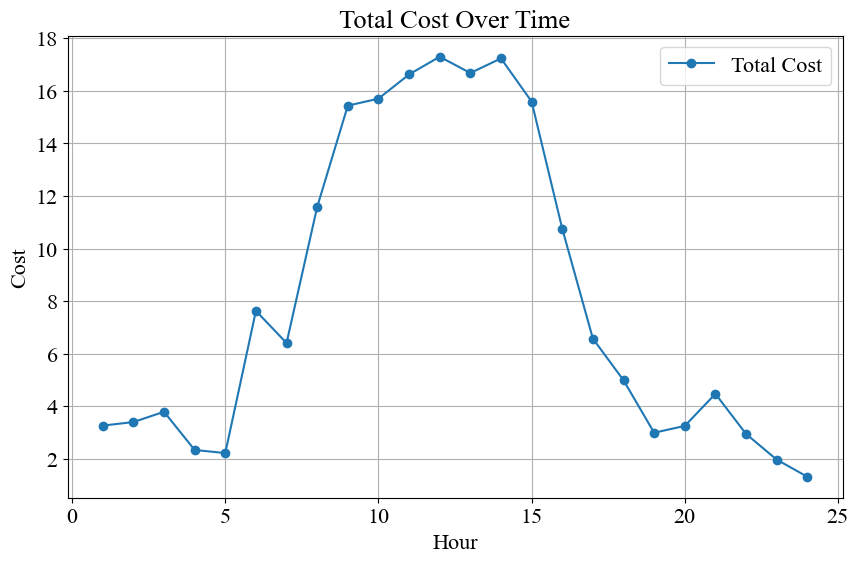

In [10]:
import matplotlib.pyplot as plt
# Set font properties
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(df) + 1), cost, label='Total Cost', marker='o')
plt.xlabel('Hour')
plt.ylabel('Cost')
plt.title('Total Cost Over Time')
plt.legend()
plt.grid(True)
plt.show()

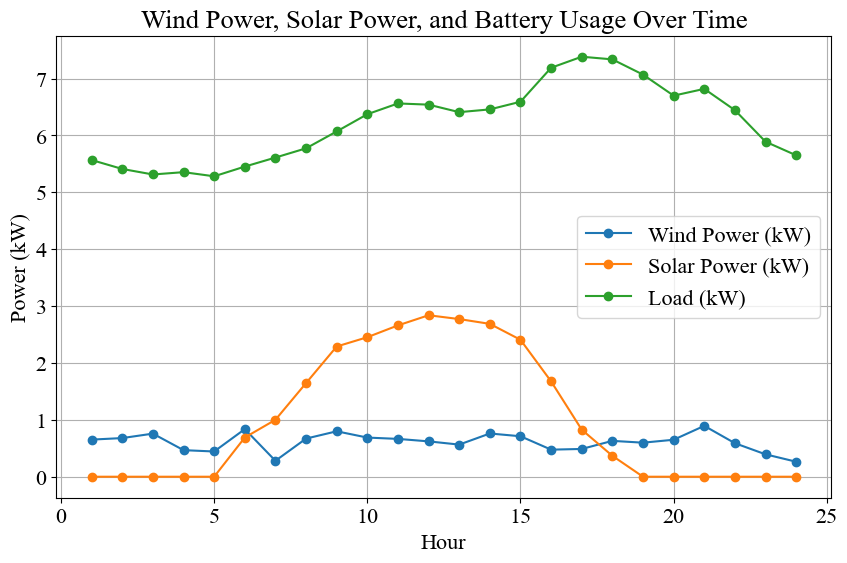

In [11]:
import matplotlib.pyplot as plt

# Extract variable values from the optimization results
wind_power_values = df['wind power'].values
solar_power_values = df['solar power'].values
load = df['Demand Electricity'].values

# Create a time array (assuming each row corresponds to an hour)
time_values = list(range(1, len(df) + 1))
# Set font properties
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Times New Roman'
# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(time_values, wind_power_values, label='Wind Power (kW)', marker='o')
plt.plot(time_values, solar_power_values, label='Solar Power (kW)', marker='o')
plt.plot(time_values, load, label='Load (kW)', marker='o')

plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Wind Power, Solar Power, and Battery Usage Over Time')
plt.legend()
plt.grid(True)
plt.show()


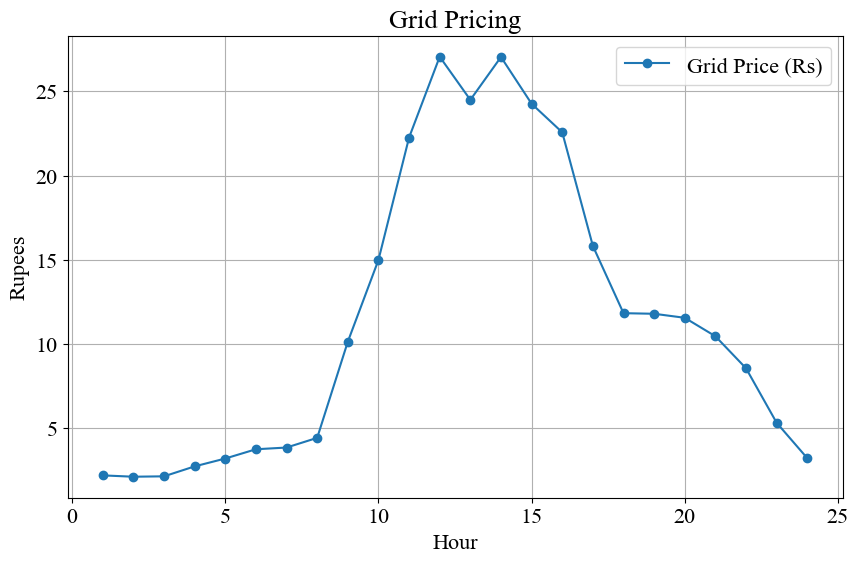

In [12]:
import matplotlib.pyplot as plt

# Extract variable values from the optimization results
gridprice = df['grid price'].values

# Create a time array (assuming each row corresponds to an hour)
time_values = list(range(1, len(df) + 1))
# Set font properties
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Times New Roman'
# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(time_values, gridprice, label='Grid Price (Rs)', marker='o')


plt.xlabel('Hour')
plt.ylabel('Rupees')
plt.title('Grid Pricing')
plt.legend()
plt.grid(True)
plt.show()

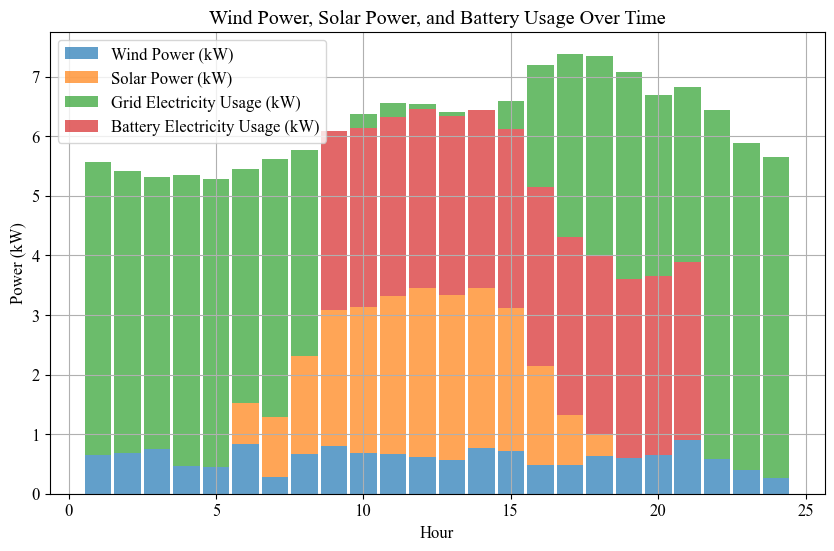

In [15]:
import matplotlib.pyplot as plt

# Extract variable values from the DataFrame
wind_power_values = df['wind power'].values
solar_power_values = df['solar power'].values
grid_usage_values = df['grid power with battery'].values
battery_usage_values = df['battery usage'].values


# Create a time array (assuming each row corresponds to an hour)
time_values = list(range(1, len(df) + 1))

# Bar width
bar_width = 0.9
# Set font properties
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'

# Plot the results as a stacked bar graph
plt.figure(figsize=(10, 6))

plt.bar(time_values, wind_power_values, width=bar_width, label='Wind Power (kW)', alpha=0.7)
plt.bar(time_values, solar_power_values, width=bar_width, bottom=wind_power_values, label='Solar Power (kW)', alpha=0.7)
plt.bar(time_values, grid_usage_values, width=bar_width, bottom=wind_power_values + solar_power_values+battery_usage_values, label='Grid Electricity Usage (kW)', alpha=0.7)
plt.bar(time_values, battery_usage_values, width=bar_width, bottom=wind_power_values + solar_power_values, label='Battery Electricity Usage (kW)', alpha=0.7)


plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Wind Power, Solar Power, and Battery Usage Over Time')
plt.legend()
plt.grid(True)
plt.show()
